# 0. Setup.

## Imports.

In [1]:
# Imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os

import nbimporter
import bioasq_libs

# Random seeds.
from transformers import set_seed
import tensorflow as tf

set_seed(42)              # For Hugging Face.
tf.random.set_seed(42)    # For tf, np, and python.

# Suppress warnings.
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

import warnings
warnings.filterwarnings(
    "ignore",
    message="torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly.*",
    category=UserWarning
)

# cuda device.
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Limit GPU memory usage.
torch.cuda.set_per_process_memory_fraction(0.9, device=0)

## Markdown table format.

In [2]:
%%html
<style>
    table {
        float: left;
        margin-right: 20px; /* Optional: Adds space between table and other content */
    }
</style>

# 1. Data Preparation.

In [2]:
from datasets import concatenate_datasets
train_ds, valid_ds, test_ds_list = bioasq_libs.load_datasets_all()
test_ds_merged = concatenate_datasets(test_ds_list)

Map:   0%|          | 0/1357 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

# 2. Overview.

## Temporary convert into df.

In [10]:
train_df = train_ds.to_pandas()

## 2.1. Features: 'question', 'snippets', 'documents'.
  - 'question': Text, one sentence for question.
  - 'snippets': Text, one to many sentences for short information.
  - 'documents': URL, one to many urls for a research paper from PubMed.

In [11]:
train_df.head()

,question,snippets,documents,labels,answer_ideal
0,Is the Wnt protein modified by notum?,Notum deacylates Wnt proteins to suppress sign...,http://www.ncbi.nlm.nih.gov/pubmed/18505598\nh...,1,"Yes, \tNotum deacylates Wnt proteins to suppre..."
1,Are Chernobyl survivors at increased risk for ...,Results: A more aggressive course of breast ca...,http://www.ncbi.nlm.nih.gov/pubmed/29787442\nh...,1,"Yes, Chernobyl survivors are at increased risk..."
2,Do proton pump inhibitors affect thyroxine abs...,"Proton-pump inhibitors, antacids and a long li...",http://www.ncbi.nlm.nih.gov/pubmed/15073769\nh...,1,"Proton-pump inhibitors, antacids and a long li..."
3,Is protein Fbw7 a SCF type of E3 ubiquitin lig...,FBW7 (F-box and WD repeat domain-containing 7)...,http://www.ncbi.nlm.nih.gov/pubmed/22665065\nh...,1,"Fbxw7 (also known as Fbw7, SEL-10, hCdc4, or h..."
4,Is cilengitide effective for treatment of glio...,RESULTS: fourteen randomized clinical trials w...,http://www.ncbi.nlm.nih.gov/pubmed/26918452\nh...,0,"No, cilengitide does not improve survival of g..."


## 2.2. Train size = 1,085.
- Very small train set.
- RAG with mid~heavy LLM is expected to win.
- Full-training is not recommended. Instead consider task-specific training like QLoRA or zero-shot learning.
- Consider data augmentation.

In [25]:
print(f"Train set size: {len(train_df)}")

Train set size: 1085


## 2.3. Length of features.
- `snippets`: Very long, and there are exceptionally long case.
- `documents`: Each url has len of 43, so there would be around 15 ~ 20 URLs generally.
> #### Caution) Some len_documents are exceptionally large, which could cause significant delay during https requests!

In [33]:
cols     = ['question', 'snippets', 'documents']
len_cols = ['len_question', 'len_snippets', 'len_documents']

train_df[len_cols] = train_df[cols].map(len)

train_df[len_cols].describe()

Length of 1 url: 43.


array([[<Axes: title={'center': 'len_question'}>,
        <Axes: title={'center': 'len_snippets'}>],
       [<Axes: title={'center': 'len_documents'}>, <Axes: >]],
      dtype=object)

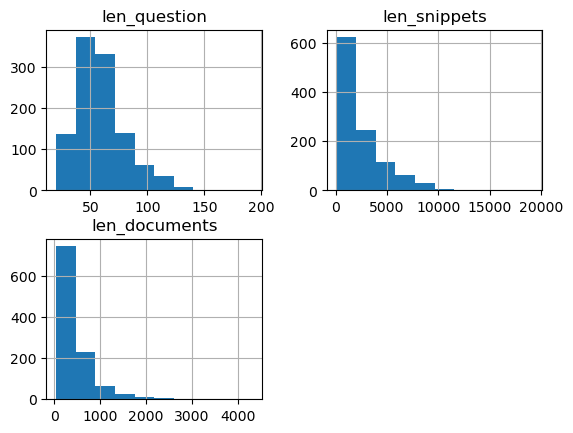

In [26]:
train_df[len_cols].hist()

In [39]:
# print len of url.
url_sample = train_df['documents'][0].split('\n')[0]
print(f"Length of 1 url: {len(url_sample)}.")

Length of 1 url: 43.


## 2.4. Contents.
- Questions seem very domain-specific. We will need specialized LLMs like PubMedBERT.
- From manual review, snippets seem to be extracted from documents, especially abstract.
- It seems we can only access abstracts via each URL.
- We need to check carefully if retrieval from URLs are necessary.

In [48]:
for i in range(3):
    sample = train_df.iloc[i]
    print(f"**question: {sample['question']}", end='\n\n')
    print(f"snippets: \n{sample['snippets']}", end='\n\n')
    print(f"num of documents: \n{len(sample['documents'])}", end='\n\n')
    print(f"label: {sample['labels']}", end='\n\n')

**question: Is the Wnt protein modified by notum?

snippets: 
Notum deacylates Wnt proteins to suppress signalling activity.
Kinetic and mass spectrometric analyses of human proteins show that Notum is a carboxylesterase that removes an essential palmitoleate moiety from Wnt proteins and thus constitutes the first known extracellular protein deacylase.
the Wnt inhibitor notum
the WNT-inhibitor notum.

num of documents: 
395

label: 1

**question: Are Chernobyl survivors at increased risk for breast cancer?

snippets: 
Results: A more aggressive course of breast cancer is observed in patients exposed to radiation from the Chernobyl accident under the age of 30 years (P < .01). 
A significant excess of multiple myeloma incidence [standardized incidence rate (SIR) 1.61 %, 95% confidence interval (CI) 1.01-2.21], thyroid cancer (SIR 4.18, 95% CI 3.76-4.59), female breast cancer (SIR 1.57 CI 1.40-1.73), and all cancers combined (SIR 1.07; 95% CI 1.05-1.09) was registered. 
Possible effects 

## 2.5. Class distribution.
- Highly uneven: 'yes' (0.74) vs 'no' (0.26).
- This would obviously make training hard.
- Should consider **class-balanced sampling**, **data augmentation**, **loss with class weights**, etc.

In [96]:
train_df['labels'].value_counts() / len(train_df)

labels
1    0.739171
0    0.260829
Name: count, dtype: float64

## 2.6. Convert back to ds.

In [50]:
from datasets import Dataset
train_ds = Dataset.from_pandas(train_df)

# 3. Non-RAG.
- No snippets or documents.
- Let's check what pretrained non-RAG LLMs can do.

## 3.1. Data Preparation.

In [74]:
cols_query     = ['question', 'labels']
train_ds_query = train_ds.select_columns(cols_query)
valid_ds_query = valid_ds.select_columns(cols_query)

train_ds_query

Dataset({
    features: ['question', 'labels'],
    num_rows: 1085
})

## 3.2. No Fine-Tuning.
- **Accuracy**: 0.44.
- Very low, because we should train a classification head, plus it is highly domain-specific, so the model was rarely seen these data during training.

In [59]:
import evaluate
from transformers import pipeline

# Model.
classifier      = pipeline("text-classification", model="distilbert-base-uncased")

# Metrics.
metric_accuracy = evaluate.load("accuracy")

# Predict, on train set.
predictions      = classifier(train_ds_query['question'])
y_pred           = [int(pred['label'].split('_')[-1]) for pred in predictions]     # convert to label.

# Compute accuracy.
accuracy = metric_accuracy.compute(predictions = y_pred, 
                                   references  = train_ds_query['labels'])

# Print.
print(f"Accuracy: {accuracy['accuracy']:.2f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Accuracy: 0.44


## 3.3. Query-Only.

### 3.3.1. Model and Tokenizer.

In [76]:
checkpoint = 'distilbert-base-uncased'

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_query   = AutoTokenizer.from_pretrained(checkpoint)
model_query       = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.3.2. Tokenize.

In [87]:
def tokenize_query(x):
    return tokenizer_query(x['question'],
                           truncation=True,
                           max_length=512,)

train_ds_query = train_ds_query.map(tokenize_query, batched=True, remove_columns=['question'])
valid_ds_query = valid_ds_query.map(tokenize_query, batched=True, remove_columns=['question'])

Map:   0%|          | 0/1085 [00:00<?, ? examples/s]

Map:   0%|          | 0/272 [00:00<?, ? examples/s]

### 3.3.2. Train.

In [93]:
# Data collator, for dynamic padding.
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

# TrainingArguments and Trainer.
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir                  = "./results",
    eval_strategy               = "epoch",
    learning_rate               = 5e-5,
    per_device_train_batch_size = 8,
    num_train_epochs            = 1,           # for test.
    save_strategy               = "epoch",
    logging_dir                 = "./logs",
)

trainer = Trainer(
    model             = model_query,
    args              = training_args,
    train_dataset     = train_ds_query,
    eval_dataset      = valid_ds_query,
    processing_class  = tokenizer,
    data_collator     = data_collator,
    compute_metrics   = bioasq_libs.compute_metrics      # Custom metrics.
)

In [102]:
# Freeze body.
for param in model_query.base_model.parameters():
    param.requires_grad = False

# Train.
trainer.train()

# Print and log results.
bioasq_libs.print_and_log_results(trainer)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Yes,F1 No,Macro F1
1,No log,0.554129,0.738971,0.849894,0.000000,0.424947


# 2025.01.08.
<Hyperparameters>
- Model        : distilbert-base-uncased
- Learning Rate: 5e-05
- Batch Size   : 8
- Epochs       : 1

<Results>
- Accuracy     : 0.739
- F1-yes       : 0.8499
- F1-no        : 0.0
- Macro-F1     : 0.4249
- Train Loss   : 0.5641
- Validation Loss: 0.5541

<Training Time>
- Total Time   : 2.48 seconds
- Time per Epoch: 2.48 seconds
- Time per Step : 0.0182 seconds



## 3.4. Train with Class Weights.

### 3.4.1. Class weights.

In [99]:
from collections import Counter

n_classes     = 2
class_counts  = Counter(train_ds_query["labels"])
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
class_weights = torch.tensor([class_weights[i] for i in range(n_classes)], device=device)

print(f"Class weights: {class_weights}")

Class weights: tensor([0.0035, 0.0012], device='cuda:0')


> #### Note) Raw Value for Class Weights.  
> Avoid normalizing class weights to 0. Raw values typically work better with loss.

### 3.4.2. Train.

In [103]:
# Reload the model.
model_query = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Data collator, for dynamic padding.
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

# TrainingArguments.
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir                  = "./results",
    eval_strategy               = "epoch",
    learning_rate               = 5e-5,
    per_device_train_batch_size = 8,
    num_train_epochs            = 1,           # for test.
    save_strategy               = "epoch",
    logging_dir                 = "./logs",
)

# Custom trainer for class weights.
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        global class_weights    # Do NOT calculate in here, it will calculate in a batch.
        
        labels        = inputs.get("labels")
        num_classes   = self.model.config.num_labels  # Total number of classes.
        device        = labels.device

        # Compute the loss.
        outputs  = model(**inputs)
        logits   = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss     = loss_fct(logits.view(-1, num_classes), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
    
trainer_class = WeightedTrainer(
    model             = model_query,
    args              = training_args,
    train_dataset     = train_ds_query,
    eval_dataset      = valid_ds_query,
    processing_class  = tokenizer,
    data_collator     = data_collator,
    compute_metrics   = bioasq_libs.compute_metrics  # Custom metrics.
)

# Train.
trainer_class.train(resume_from_checkpoint=None)

# Print and log results.
bioasq_libs.print_and_log_results(trainer_class)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Yes,F1 No,Macro F1
1,No log,0.612932,0.702206,0.786280,0.509091,0.647685


# 2025.01.08.
<Hyperparameters>
- Model        : distilbert-base-uncased
- Learning Rate: 5e-05
- Batch Size   : 8
- Epochs       : 1

<Results>
- Accuracy     : 0.7022
- F1-yes       : 0.7863
- F1-no        : 0.5091
- Macro-F1     : 0.6477
- Train Loss   : 0.6748
- Validation Loss: 0.6129

<Training Time>
- Total Time   : 7.38 seconds
- Time per Epoch: 7.38 seconds
- Time per Step : 0.0543 seconds



> #### Note) Override Method in Custom Trainer.
> Methods like `def compute_loss` only applies on 1 batch.  
> You should be very careful not to calculate what should be done outside.  
> e.g. Calculating `class_weights` inside will prevent normal training, but **it could be hard to find this reason!**

## 3.1. Check Class Distribution.

In [ ]:
labels = train_ds_query['labels']
pd.Series(labels).value_counts() / len(labels)

## 3.2. Custom Trainer for Class Weights.

In [ ]:
# Reload the model.
model_query = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir                  = "./results",
    eval_strategy               = "epoch",
    learning_rate               = 5e-5,
    per_device_train_batch_size = 8,
    num_train_epochs            = 5,
    save_strategy               = "epoch",
    logging_dir                 = "./logs",
)

trainer = Trainer(
    model             = model_query,
    args              = training_args,
    train_dataset     = train_ds_query,
    eval_dataset      = valid_ds_query,
    processing_class  = tokenizer,
    compute_metrics   = bioasq_libs.compute_metrics      # Custom metrics.
)

# Custom trainer for class weights.
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels        = inputs.get("labels")
        num_classes   = self.model.config.num_labels  # Total number of classes.
        device        = labels.device

        # Calculate class weights directly based on label frequency in the current batch.
        class_counts  = torch.bincount(labels, minlength=num_classes).float()
        class_weights = torch.zeros(num_classes, device=device)

        # Avoid division by zero for missing classes.
        class_weights[class_counts > 0] = 1.0 / class_counts[class_counts > 0]
        class_weights /= class_weights.sum()  # Normalize weights, to sum to 1.

        # Compute the loss.
        outputs  = model(**inputs)
        logits   = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss     = loss_fct(logits.view(-1, num_classes), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
    
# Use WeightedTrainer.
trainer_class = WeightedTrainer(
    model             = model_query,
    args              = training_args,
    train_dataset     = train_ds_query,
    eval_dataset      = valid_ds_query,
    processing_class  = tokenizer,
    compute_metrics   = bioasq_libs.compute_metrics  # Custom metrics.
)

## 3.3. Train.

In [ ]:
# Train.
trainer_class.train(resume_from_checkpoint=None)

# Print and log results.
bioasq_libs.print_and_log_results(trainer_class)

# 4. Training Optimization.
- Before we move on to real fine-tuning with real LLMs, we should optimize the training procedure. (~~unless you have x10 4090s~~)
- **Optuna**: Hyperparameter tuning.
- **QLoRA**: 8-bits quantization and PEFT using LoRA.

## 4.1. 8-bits Quantization.

In [151]:
from transformers import BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

skip_modules = ["classifier", "pre_classifier"]    # This modules are not quantized. Need to check with different pretrained LLMs.

quantization_config = BitsAndBytesConfig(
    load_in_4bit            = True,                # Quantize into 4-bits.                  
    llm_int4_threshold      = 6.0,                 # Layers whose norm of weights <= 6.0 are not quantized. 
    bnb_4bit_compute_dtype  = torch.float16,       
    low_cpu_mem_usage       = True,
    llm_int8_skip_modules   = skip_modules         # Need to check with different pretrained LLMs.
)

model_query = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    num_labels          = 2,
    quantization_config = quantization_config,
).to(device)

model_query = prepare_model_for_kbit_training(model_query)     # prepare quantized model for training.

Unused kwargs: ['llm_int4_threshold', 'low_cpu_mem_usage']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


> #### Note) `llm_int8_skip_modules   = ["classifier", "pre_classifier"]`.
> Without this, error will occur with LoRA.  
> RuntimeError: only Tensors of floating point dtype can require gradients.  
> This error is related with library versions, which could be temporary.  
> https://github.com/huggingface/peft/issues/1720

> #### Note) `device_map` in the `model()`.
> Do NOT set `device_map` at inside of `model()` initialization.  
> It will cause conflicts with Optuna, because it will not be string inside of init.  
> Instead, use `model().to(device)`.  
> TypeError: device() received an invalid combination of arguments - got (NoneType), but expected one of:
> \* (torch.device device)
>      didn't match because some of the arguments have invalid types: (NoneType)
> \* (str type, int index = -1)

> #### Note) Training of Quantized Model.
> Quantized model is directly trainable, because training requires not-quantized calculations.  
> But adapter-based PEFTs like LoRA makes it possible, cuz it adds additional layers in addition to existing layers!

## 4.2. LoRA.

### 4.2.1. Check model's target module.

In [129]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"Layer name: {name}")

Layer name: distilbert.transformer.layer.0.attention.q_lin
Layer name: distilbert.transformer.layer.0.attention.k_lin
Layer name: distilbert.transformer.layer.0.attention.v_lin
Layer name: distilbert.transformer.layer.0.attention.out_lin
Layer name: distilbert.transformer.layer.0.ffn.lin1
Layer name: distilbert.transformer.layer.0.ffn.lin2
Layer name: distilbert.transformer.layer.1.attention.q_lin
Layer name: distilbert.transformer.layer.1.attention.k_lin
Layer name: distilbert.transformer.layer.1.attention.v_lin
Layer name: distilbert.transformer.layer.1.attention.out_lin
Layer name: distilbert.transformer.layer.1.ffn.lin1
Layer name: distilbert.transformer.layer.1.ffn.lin2
Layer name: distilbert.transformer.layer.2.attention.q_lin
Layer name: distilbert.transformer.layer.2.attention.k_lin
Layer name: distilbert.transformer.layer.2.attention.v_lin
Layer name: distilbert.transformer.layer.2.attention.out_lin
Layer name: distilbert.transformer.layer.2.ffn.lin1
Layer name: distilbert.tra

### 4.2.2. LoRA configuration.

In [154]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r              = 8,                     # Rank of the low-rank decomposition.
    lora_alpha     = 32,                    # Scaling factor.
    lora_dropout   = 0.1,                   # Dropout.
    target_modules = "all-linear",          # Model-agnostic.
    task_type      = "SEQ_CLS",             # Task type = sequential clf.
    init_lora_weights="olora")

# Prepare model with LoRA adapters.
model_query = get_peft_model(model_query, lora_config)    

# I don't know why but it occurs TypeError, but it perfectly works in Optuna's objective ftn! 
# To avoid this, use LoRA first then quantization.

ValueError: Target module Dropout(p=0.1, inplace=False) is not supported. Currently, only the following modules are supported: `torch.nn.Linear`, `torch.nn.Embedding`, `torch.nn.Conv2d`, `torch.nn.Conv3d`, `transformers.pytorch_utils.Conv1D`.

## 4.3. Train.

In [153]:
# Training args for 8-bits quantization, using bitsandbytes.  
training_args = TrainingArguments(
    output_dir              = "./results",
    eval_strategy           = "epoch",
    num_train_epochs        = 1,
    save_strategy           = "epoch",
    logging_dir             = "./logs",
    per_device_train_batch_size = 8,
    learning_rate           = 5e-5,                         # Use tuned learning rate.
    optim                   = "adamw_bnb_8bit",             # 8-bits Quantization of Optimizer.
)

# Trainer.
trainer_class = WeightedTrainer(
    model             = model_query,
    args              = training_args,
    train_dataset     = train_ds_query,
    eval_dataset      = valid_ds_query,
    processing_class  = tokenizer,
    compute_metrics   = bioasq_libs.compute_metrics  # Custom metrics.
)

# Train.
trainer_class.train()

# Print results.
bioasq_libs.print_and_log_results(trainer_class)

ValueError: You cannot perform fine-tuning on purely quantized models. Please attach trainable adapters on top of the quantized model to correctly perform fine-tuning. Please see: https://huggingface.co/docs/transformers/peft for more details

## 4.4. Hyperparameter Tuning with Optuna.
- Just put everything so far into `def objective`!

In [155]:
# Define a training loop for Optuna.
import optuna
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import BitsAndBytesConfig

# Objective ftn.
def objective(trial, model):
    # Hyperparameters to tune.
    hyperparams = {
        'learning_rate': trial.suggest_float('learning_rate', 3e-5, 5e-5, log=True)
    }
    
    # Quantization.
    quantization_config = BitsAndBytesConfig(
        load_in_4bit            = True, 
        llm_int4_threshold      = 6.0,
        bnb_4bit_compute_dtype  = torch.float16,
        low_cpu_mem_usage       = True,
        llm_int8_skip_modules   = ["classifier", "pre_classifier"]
    )
    
    device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_query = AutoModelForSequenceClassification.from_pretrained(
        checkpoint, 
        num_labels          = 2,
        quantization_config = quantization_config,
    ).to(device)
    
    model_query = prepare_model_for_kbit_training(model_query)

    # Apply LoRA.
    lora_config = LoraConfig(
    r              = 8,                     # Rank of the low-rank decomposition.
    lora_alpha     = 32,                    # Scaling factor.
    lora_dropout   = 0.1,                   # Dropout.
    target_modules = ["q_lin", "v_lin"],    # Specify the target modules.
    task_type      = "SEQ_CLS",              # Task type = sequential clf.
    init_lora_weights="olora")
    
    model_query = get_peft_model(model_query, lora_config)
    
    # Training args for 8-bits quantization, using bitsandbytes.  
    training_args = TrainingArguments(
        output_dir              = "./results",
        eval_strategy           = "epoch",
        num_train_epochs        = 1,
        save_strategy           = "epoch",
        logging_dir             = "./logs",
        per_device_train_batch_size = 8,
        learning_rate           = hyperparams['learning_rate'],  # Use tuned learning rate.
        optim                   = "adamw_bnb_8bit",             # 8-bits Quantization of Optimizer.
    )
    
    # Trainer.
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
            labels        = inputs.get("labels")
            num_classes   = self.model.config.num_labels  # Total number of classes.
            device        = labels.device

            # Calculate class weights directly based on label frequency in the current batch.
            class_counts  = torch.bincount(labels, minlength=num_classes).float()
            class_weights = torch.zeros(num_classes, device=device)

            # Avoid division by zero for missing classes.
            class_weights[class_counts > 0] = 1.0 / class_counts[class_counts > 0]
            class_weights /= class_weights.sum()  # Normalize weights, to sum to 1.

            # Compute the loss.
            outputs  = model(**inputs)
            logits   = outputs.get("logits")
            loss_fct = nn.CrossEntropyLoss(weight=class_weights)
            loss     = loss_fct(logits.view(-1, num_classes), labels.view(-1))
            return (loss, outputs) if return_outputs else loss
    
    trainer_class = WeightedTrainer(
        model             = model_query,
        args              = training_args,
        train_dataset     = train_ds_query,
        eval_dataset      = valid_ds_query,
        processing_class  = tokenizer,
        compute_metrics   = bioasq_libs.compute_metrics  # Custom metrics.
    )

    # Train.
    trainer_class.train()
    
    # Evaluate.
    eval_results = trainer_class.evaluate()
    
    # Results.
    history          = trainer.state.log_history
    total_train_time = sum([log.get("train_runtime", 0) for log in history])
    
    trial.set_user_attr(key="model_name", value=trainer.model.name_or_path)
    trial.set_user_attr(key="best_params", value=hyperparams)
    trial.set_user_attr(key="results", value=eval_results)
    trial.set_user_attr(key="training_time", value=total_train_time)
    
    # Print and log trainer.
    bioasq_libs.print_and_log_results(trainer_class)
    
    return eval_results["eval_macro_f1"]

# Create Optuna study and optimize.
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, model_query), n_trials=2)

# Best trial.
bioasq_libs.print_trial(study.best_trial)

[I 2025-01-08 17:31:39,104] A new study created in memory with name: no-name-7a076281-5ef3-436e-8dfd-8e7114aa0eec
Unused kwargs: ['llm_int4_threshold', 'low_cpu_mem_usage']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Yes,F1 No,Macro F1
1,No log,0.680375,0.702206,0.805755,0.362205,0.583980


[I 2025-01-08 17:31:50,714] Trial 0 finished with value: 0.5839800600464511 and parameters: {'learning_rate': 3.4338038088336266e-05}. Best is trial 0 with value: 0.5839800600464511.
Unused kwargs: ['llm_int4_threshold', 'low_cpu_mem_usage']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


# 2025.01.08.
<Hyperparameters>
- Model        : distilbert-base-uncased
- Learning Rate: 3.4338038088336266e-05
- Batch Size   : 8
- Epochs       : 1

<Results>
- Accuracy     : 0.7022
- F1-yes       : 0.8058
- F1-no        : 0.3622
- Macro-F1     : 0.584
- Train Loss   : 0.6897
- Validation Loss: 0.6804

<Training Time>
- Total Time   : 8.98 seconds
- Time per Epoch: 8.98 seconds
- Time per Step : 0.0661 seconds



`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Yes,F1 No,Macro F1
1,No log,0.679380,0.702206,0.799007,0.425532,0.612270


[I 2025-01-08 17:32:02,043] Trial 1 finished with value: 0.6122696795311757 and parameters: {'learning_rate': 3.4319307052935054e-05}. Best is trial 1 with value: 0.6122696795311757.


# 2025.01.08.
<Hyperparameters>
- Model        : distilbert-base-uncased
- Learning Rate: 3.4319307052935054e-05
- Batch Size   : 8
- Epochs       : 1

<Results>
- Accuracy     : 0.7022
- F1-yes       : 0.799
- F1-no        : 0.4255
- Macro-F1     : 0.6123
- Train Loss   : 0.6894
- Validation Loss: 0.6794

<Training Time>
- Total Time   : 8.98 seconds
- Time per Epoch: 8.98 seconds
- Time per Step : 0.066 seconds

<Hyperparameters>
- Model: distilbert-base-uncased
- learning_rate   : 3.432e-05

<Results>
- eval_loss       : 0.6794
- eval_accuracy   : 0.7022
- eval_f1_yes     : 0.799
- eval_f1_no      : 0.4255
- eval_macro_f1   : 0.6123
- eval_samples_per_second : 456.8
- eval_steps_per_second : 57.1
- epoch           : 1.0
- Training time  : 2.48


# 5. Document Retrieval.

## 5.1. Data Preparation.

In [156]:
cols_rag     = ['question', 'labels', 'snippets', 'documents']
train_ds_rag = train_ds.select_columns(cols_rag)
valid_ds_rag = valid_ds.select_columns(cols_rag)

## 5.2. Document Retrieval.

### 5.2.1. Prompt.

In [ ]:
prompt_exact = """\
Question: {question}
Snippets:
{snippets}
Retrieved Chunks:
{retrieved_chunks}
Answer:
"""

### 5.2.2. Retrieval - from each doc.

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

def retrieve_from_each_doc(query, documents, chunk_size, chunk_overlap):
    
    # Text splitter.
    text_splitter = CharacterTextSplitter(separator     = ". ", 
                                          chunk_size    = chunk_size, 
                                          chunk_overlap = chunk_overlap)
    
    # Embedding model.
    model_kwargs    = {'device': device}
    model_name      = "sentence-transformers/all-MiniLM-L6-v2"
    embedding_model = HuggingFaceEmbeddings(model_name   = model_name,
                                            model_kwargs = model_kwargs)
    
    # For each document, split, embed, and retrieve the most relevant chunk.
    retrievals = []
    for doc in documents:
        chunks = text_splitter.split_text(doc)                    # Split the document into chunks.
        
        vector_store = FAISS.from_texts(chunks, embedding_model)  # FAISS vector store.
        
        # Similarity search.
        result = vector_store.similarity_search(query, k=1)       # Similarity search to retrieve the top result for this document.
        retrievals.append(result[0].page_content)                 # Store the most relevant chunk.
        
    return retrievals

### 5.2.3. Retrieval - from all docs.

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

def retrieve_from_docs(query, documents, top_k_retrieval, chunk_size, chunk_overlap):
    
    # Text splitter.
    text_splitter = CharacterTextSplitter(separator      = ". ", 
                                          chunk_size     = chunk_size, 
                                          chunk_overlap  = chunk_overlap)
    
    # Embedding model.
    model_kwargs    = {'device': device}
    model_name      = "sentence-transformers/all-MiniLM-L6-v2"
    embedding_model = HuggingFaceEmbeddings(model_name    = model_name,
                                            model_kwargs  = model_kwargs)
    
    # For each document, split, embed, and retrieve the most relevant chunk.
    retrievals = []
    chunks     = []
    for doc in documents:
        chunks.extend(text_splitter.split_text(doc))                     # Split the document into chunks
        
    vector_store = FAISS.from_texts(chunks, embedding_model)             # FAISS vector store.

    result = vector_store.similarity_search(query, k=top_k_retrieval)    # Similarity search to retrieve top-k relevant documents.
    retrievals.extend([res.page_content for res in result])              # Store relevant chunks.
    
    return retrievals

### 5.2.4. Multithread and Async.
- 5.2.4.2. ~ 5.2.4.7. are only for reference, use 5.2.4.8. Final.

#### 5.2.4.1. Test Hyperparameters.

In [ ]:
# Test hyperparameters.
chunk_size      = 400
chunk_overlap   = 20
num_samples     = 256
batch_sizes     = [16]
num_workerss    = [32]

# Create a smaller subset for testing
small_train_ds_rag = train_ds_rag.select(range(num_samples))  # Select the first 256 examples

#### 5.2.4.2. Single sample. 
- Too slow!
- Manual search for tags will be replaced with BeautifulSoap later.

In [ ]:
from langchain.document_loaders import WebBaseLoader

def preprocessing_rag(sample):
    results = []
    doc_urls  = sample['documents'].split('\n')    # URL of each document.
    documents = []

    for url in doc_urls:
        loader           = WebBaseLoader(url)
        document         = loader.load()[0]
        abstract_pattern_begin = 'AbstractPubMedPMID\n\n\n        Abstract\n        \n      \n\n\n      \n      '
        abstract_idx_begin     = document.page_content.find(abstract_pattern_begin) + len(abstract_pattern_begin)
        abstract_idx_end       = document.page_content.find('\n', abstract_idx_begin)

        abstract         = document.page_content[abstract_idx_begin:abstract_idx_end]
        documents.append(abstract)

    retrieved_chunks = retrieve_from_each_doc(query     = sample["question"],
                                              documents = documents)

    # Join retrieved chunks into a single string.
    retrieved_chunks = "\n".join(retrieved_chunks)

    # Use the prompt template to create the input text.
    input_text = prompt.format(
        question          = sample["question"],
        snippets          = sample["snippets"],
        retrieved_chunks  = retrieved_chunks
    )

    # Use the encoded label directly.
    labels = sample["labels"]
    
    return {'input_text': input_text, 
            'labels': labels}

#### 5.2.4.3. Batched, Single Thread.
- Takes almost 26 hrs.

In [ ]:
from datetime import datetime
import requests
from langchain.document_loaders import WebBaseLoader

call_count = 0  # Initialize a global counter.

def preprocessing_rag(batch):
    global call_count
    call_count += 1 
    
    # Current time.
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')  # Get the current time.
    print(f'{call_count}th Batch started at: {current_time}.')
    
    # Process each sample in the batch.
    inputs = []
    labels = []
    
    total_urls_in_batch = 0
    for idx in range(len(batch["question"])):
        question  = batch['question'][idx]
        snippets  = batch['snippets'][idx]
        documents = batch['documents'][idx]
        label     = batch['labels'][idx]
        
        # Split documents into URLs.
        doc_urls = documents.split("\n")
        doc_contents = []
        
        total_urls_in_batch += len(doc_urls)

        # Process each document URL.
        for url in doc_urls:
            try:
                response = requests.get(url, timeout=10)  # Timeout in seconds.
                response.raise_for_status()               # Raise HTTPError for bad responses (4xx and 5xx).

                loader   = WebBaseLoader(url)
                document = loader.load()[0]
                
                abstract_pattern_begin = 'AbstractPubMedPMID\n\n\n        Abstract\n        \n      \n\n\n      \n      '
                abstract_idx_begin = document.page_content.find(abstract_pattern_begin)
                
                if abstract_idx_begin != -1:
                    abstract_idx_begin += len(abstract_pattern_begin)
                    abstract_idx_end = document.page_content.find('\n', abstract_idx_begin)
                    abstract = document.page_content[abstract_idx_begin:abstract_idx_end]
                else:
                    abstract = "Abstract not found"
                
                doc_contents.append(abstract)
                
            except requests.exceptions.Timeout:
                print(f"Timeout occurred for URL {url}.")
            except Exception as e:
                print(f"Failed to load URL {url}: {e}")
                continue
        
        # Retrieve chunks.
        retrieved_chunks = retrieve_from_each_doc(query=question, documents=doc_contents)
        retrieved_chunks = "\n".join(retrieved_chunks)

        # Format input using prompt.
        input_text = prompt.format(
            question=question,
            snippets=snippets,
            retrieved_chunks=retrieved_chunks,
        )
        
        # Add processed input and label to the batch output.
        inputs.append(input_text)
        labels.append(label)
        
        print(f'question done: {question}')
    
    # Finish time.
    print(f'total_urls_in_batch = {total_urls_in_batch}')
    
    # Return a dictionary of lists for the batch.
    return {"input": inputs, "label": labels}


In [ ]:
call_count    = 0 

for batch_size in batch_sizes:
    for num_workers in num_workerss:
        train_ds_rag_prep_small = small_train_ds_rag.map(
            preprocessing_rag,
            desc        = f"Preprocessing (batch_size={batch_size}, num_workers={num_workers})",
            batched     = True,
            batch_size  = batch_size  
        )

#### 5.2.4.4. Multithread using `ThreadPoolExecutor`.
- Drastically decreases running time, like few hours!

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from langchain.document_loaders import WebBaseLoader
import requests
from datasets import Dataset
from datetime import datetime
import time

def fetch_url(url):
    """Fetch content from a URL with timeout handling."""
    try:
        response = requests.get(url, timeout=10)   # 10s timeout.
        response.raise_for_status()                # Raise HTTPError for bad responses (4xx and 5xx).
        
        loader   = WebBaseLoader(url)
        document = loader.load()[0]
        
        abstract_pattern_begin = 'AbstractPubMedPMID\n\n\n        Abstract\n        \n      \n\n\n      \n      '
        abstract_idx_begin = document.page_content.find(abstract_pattern_begin)
        if abstract_idx_begin != -1:
            abstract_idx_begin += len(abstract_pattern_begin)
            abstract_idx_end = document.page_content.find('\n', abstract_idx_begin)
            
            return document.page_content[abstract_idx_begin:abstract_idx_end]
        else:
            return "Abstract not found"
        
    except requests.exceptions.Timeout:
        return "Timeout occurred"
    
    except Exception as e:
        return f"Failed to load URL: {str(e)}"

def process_batch_parallel(batch):
    global call_count
    call_count += 1
    
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f'{call_count}th Batch started at: {current_time}.')
    
    inputs = []
    labels = []

    for idx in range(len(batch["question"])):
        question = batch['question'][idx]
        snippets = batch['snippets'][idx]
        documents = batch['documents'][idx]
        label = batch['labels'][idx]

        doc_urls = documents.split("\n")
        doc_contents = []

        # Parallel fetching of URLs.
        global num_workers
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            future_to_url = {executor.submit(fetch_url, url): url for url in doc_urls}
            for future in as_completed(future_to_url):
                doc_contents.append(future.result())
        
        retrieved_chunks = retrieve_from_each_doc(query=question, documents=doc_contents)
        retrieved_chunks = "\n".join(retrieved_chunks)

        input_text = prompt.format(
            question=question,
            snippets=snippets,
            retrieved_chunks=retrieved_chunks,
        )
        
        inputs.append(input_text)
        labels.append(label)
    
    # Save intermediate dataset, cuz it could take several hours.
    batch_dataset = Dataset.from_dict({"input": inputs, "label": labels})
    save_path = "rag/train_ds_rag_prep"
    os.makedirs(save_path, exist_ok=True)
    batch_dataset.save_to_disk(f"{save_path}/batch_{call_count}")
    
    return {"input": inputs, "label": labels}

In [ ]:
call_count    = 0  

for batch_size in batch_sizes:
    for num_workers in num_workerss:
        train_ds_rag_prep_small = small_train_ds_rag.map(
            process_batch_parallel,
            desc=f"Preprocessing (batch_size={batch_size}, num_workers={num_workers})",
            batched=True,
            batch_size=batch_size  # Use the current batch_size
        )

> #### Note) Many Requests at once.
> Request may fail with too many requests given period, especially multithread implementation!  
> Failed to load URL http://www.ncbi.nlm.nih.gov/pubmed/26623375: HTTPSConnectionPool(host='www.ncbi.nlm.nih.gov', port=443): Max retries exceeded with url: /pubmed/26623375 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000210C236C3D0>: Failed to establish a new connection: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다'))

#### 5.2.4.5. `requests.Session`.
- Better but still slow.

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from langchain.document_loaders import WebBaseLoader
import requests
from datasets import Dataset
from datetime import datetime
import time

def fetch_url_session(session, url):
    """Fetch content from a URL with timeout handling."""
    try:
        with session.get(url, timeout=10) as response:
            response.raise_for_status()
            loader = WebBaseLoader(url)
            document = loader.load()[0]
            abstract_pattern_begin = 'AbstractPubMedPMID\n\n\n        Abstract\n        \n      \n\n\n      \n      '
            abstract_idx_begin = document.page_content.find(abstract_pattern_begin)
            if abstract_idx_begin != -1:
                abstract_idx_begin += len(abstract_pattern_begin)
                abstract_idx_end = document.page_content.find('\n', abstract_idx_begin)
                return document.page_content[abstract_idx_begin:abstract_idx_end]
            else:
                return "Abstract not found"
    except requests.exceptions.Timeout:
        return "Timeout occurred"
    except Exception as e:
        return f"Failed to load URL: {str(e)}"

def process_batch_parallel_session(batch):
    global call_count
    call_count += 1
    
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f'{call_count}th Batch started at: {current_time}.')
    
    inputs = []
    labels = []

    for idx in range(len(batch["question"])):
        question = batch['question'][idx]
        snippets = batch['snippets'][idx]
        documents = batch['documents'][idx]
        label = batch['labels'][idx]

        doc_urls = documents.split("\n")
        doc_contents = []

        # Parallel fetching of URLs.
        global num_workers
        with requests.Session() as session:  # Use a session for connection pooling.
            with ThreadPoolExecutor(max_workers=num_workers) as executor:
                future_to_url = {executor.submit(fetch_url_session, session, url): url for url in doc_urls}
                for future in as_completed(future_to_url):
                    doc_contents.append(future.result())
        
        # Process the retrieved content
        retrieved_chunks = retrieve_from_docs(query            = question, 
                                              documents        = doc_contents,
                                              top_k_retrieval  = top_k_retrieval,
                                              chunk_size       = chunk_size,
                                              chunk_overlap    = chunk_overlap)
        
        retrieved_chunks = "\n".join(retrieved_chunks)

        input_text = prompt.format(
            question=question,
            snippets=snippets,
            retrieved_chunks=retrieved_chunks,
        )
        
        inputs.append(input_text)
        labels.append(label)
        
        print(f'-- {idx+1}th question done: {question}')
    
    # Save intermediate dataset.
    batch_dataset = Dataset.from_dict({"input": inputs, "label": labels})
    save_path = "rag/train_ds_rag_prep"
    os.makedirs(save_path, exist_ok=True)
    batch_dataset.save_to_disk(f"{save_path}/batch_{call_count}")
    
    return {"input": inputs, "label": labels}

In [ ]:
# Apply map function with parallel processing
call_count    = 0  # Initialize a global counter.
for batch_size in batch_sizes:
    for num_workers in num_workerss:
        train_ds_rag_prep_small = small_train_ds_rag.map(
            process_batch_parallel_session,
            desc=f"Preprocessing (batch_size={batch_size}, num_workers={num_workers})",
            batched=True,
            batch_size=batch_size  # Use the current batch_size
        )


#### 5.2.4.6. `asyncio`.
- Asyncronized http and io.
- Done within 60 ~ 80 mins! 
- `BeautifulSoup` to parse html efficiently.

In [ ]:
import os
import aiohttp
import asyncio
from bs4 import BeautifulSoup
from datasets import Dataset
from datetime import datetime
import time

async def fetch_url_async(session, url):
    """Fetch content from a URL asynchronously."""
    try:
        async with session.get(url, timeout=10) as response:
            html = await response.text()
            soup = BeautifulSoup(html, 'html.parser')
            
            abstract_div = soup.find('div', class_='abstract-content selected')
            
            if abstract_div:
                abstract_list = abstract_div.find_all('p')
                
                # if abstract is found, return with title.
                if abstract_list:   
                    abstract = " ".join(p.get_text(strip=True) for p in abstract_list)
                    return abstract
                else:
                    return f"abstract not found."
                
            else:
                return f"abstract_div not found."
            
    except asyncio.TimeoutError:
        return f"Timeout occurred: {url}"
    
    except Exception as e:
        return f"Failed to load URL: {str(e)}"

async def fetch_all_urls_async(doc_urls):
    """Fetch all URLs concurrently using aiohttp."""
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_url_async(session, url) for url in doc_urls]
        
        return await asyncio.gather(*tasks)

async def process_batch_parallel_async(batch, call_count, top_k_retrieval, chunk_size, chunk_overlap):
    """Process a batch asynchronously."""
    start_time = time.time()
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    inputs = []
    labels = []

    for idx in range(len(batch["question"])):
        question = batch['question'][idx]
        snippets = batch['snippets'][idx]
        documents = batch['documents'][idx]
        label = batch['labels'][idx]

        doc_urls = documents.split("\n")
        doc_contents = await fetch_all_urls_async(doc_urls)  # Fully async fetch.

        # Process the retrieved content.
        retrieved_chunks = retrieve_from_docs(query            = question, 
                                              documents        = doc_contents,
                                              top_k_retrieval  = top_k_retrieval,
                                              chunk_size       = chunk_size,
                                              chunk_overlap    = chunk_overlap)
        
        # Normalize Snippets to search the matches with retrieved_chunks.
        import string
        
        def normalize(text):
            return text.strip().lower().rstrip(string.punctuation)
        
        snippets_set = set(normalize(sentence) 
                           for snippet in snippets.split('\n')
                           for sentence in snippet.split('. '))
        
        # Delete chunks that are already in snippets.
        retrieved_chunks_unique = [chunk for chunk in retrieved_chunks
                                   if normalize(chunk) not in snippets_set]
    
        retrieved_chunks_unique = "\n".join(retrieved_chunks_unique)

        input_text = prompt_exact.format(
            question          = question,
            snippets          = snippets,
            retrieved_chunks  = retrieved_chunks_unique,
        )

        inputs.append(input_text)
        labels.append(label)

    # Don't need to save, it's very fast now :)
    '''
    # Save intermediate dataset, for each batch.
    batch_dataset = Dataset.from_dict({"input": inputs, "label": labels})
    save_path = "rag/train_ds_rag_prep"
    os.makedirs(save_path, exist_ok=True)
    batch_dataset.save_to_disk(f"{save_path}/batch_{call_count}")
    '''
    
    elapsed_time = time.time() - start_time
    print(f'{call_count}th Batch completed in {elapsed_time:.2f} seconds. ({(elapsed_time / len(batch["question"])):.2f}s/ examples)')

    return {"input": inputs, "labels": labels}


> #### Note) Parse `aiohttp.ClientSession().get`.  
> `aiohttp.ClientSession().get()` returns a raw HTML, which should be parsed by `BeautifulSoup`!

#### 5.2.4.7. Increased `batch_size` and `num_workers`.
- Not very useful.

In [ ]:
# Hyperparameters.
chunk_size      = 400
chunk_overlap   = 20
batch_size      = 32
num_workers     = 128

async def process_all_batches(dataset, batch_size):
    global call_count
    call_count = 0  # Initialize a global counter.
    
    all_inputs = []
    all_labels = []
    
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i + batch_size]  # Extract a batch
        call_count += 1
        result = await process_batch_parallel(batch, call_count)  # Process each batch asynchronously

        all_inputs.extend(result["input"])
        all_labels.extend(result["label"])
        
    # Combine all processed batches into a single dataset
    return Dataset.from_dict({"input": all_inputs, "label": all_labels})
        
# Run the process and set train_ds_rag_prep
print(f"Processing with batch_size={batch_size}, num_workers={num_workers}.")
print(f"- Num of samples = {len(small_train_ds_rag)}")
print(f"- Num of batches = {int(len(small_train_ds_rag) / batch_size)}")

small_train_ds_rag_prep = await process_all_batches(small_train_ds_rag, batch_size=batch_size)

# Note that additional combinations also didn't show improve.

#### 5.2.4.8. Final.

In [51]:
import os
import aiohttp
import asyncio
from bs4 import BeautifulSoup
from datasets import Dataset
from datetime import datetime
import time

from langchain.text_splitter import CharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

prompt_exact = """\
Question: {question}
Snippets:
{snippets}
Retrieved Chunks:
{retrieved_chunks}
Answer:
"""

def retrieve_from_docs(query, documents, top_k_retrieval, chunk_size, chunk_overlap):
    
    # Text splitter.
    text_splitter = CharacterTextSplitter(separator      = ". ", 
                                          chunk_size     = chunk_size, 
                                          chunk_overlap  = chunk_overlap)
    
    # Embedding model.
    model_kwargs    = {'device': device}
    model_name      = "sentence-transformers/all-MiniLM-L6-v2"
    embedding_model = HuggingFaceEmbeddings(model_name    = model_name,
                                            model_kwargs  = model_kwargs)
    
    # For each document, split, embed, and retrieve the most relevant chunk.
    retrievals = []
    chunks     = []
    for doc in documents:
        chunks.extend(text_splitter.split_text(doc))                     # Split the document into chunks
        
    vector_store = FAISS.from_texts(chunks, embedding_model)             # FAISS vector store.

    result = vector_store.similarity_search(query, k=top_k_retrieval)    # Similarity search to retrieve top-k relevant documents.
    retrievals.extend([res.page_content for res in result])              # Store relevant chunks.
    
    return retrievals

async def fetch_url_async(session, url):
    """Fetch content from a URL asynchronously."""
    try:
        async with session.get(url, timeout=10) as response:
            html = await response.text()
            soup = BeautifulSoup(html, 'html.parser')
            
            abstract_div = soup.find('div', class_='abstract-content selected')
            if abstract_div:
                abstract_list = abstract_div.find_all('p')
                
                # if abstract is found, return with title.
                if abstract_list:   
                    abstract = " ".join(p.get_text(strip=True) for p in abstract_list)
                    return abstract
                else:
                    return f"abstract not found."
                
            else:
                return f"abstract_div not found."
            
    except asyncio.TimeoutError:
        return f"Timeout occurred: {url}"
    
    except Exception as e:
        return f"Failed to load URL: {str(e)}"

async def fetch_all_urls_async(doc_urls):
    """Fetch all URLs concurrently using aiohttp."""
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_url_async(session, url) for url in doc_urls]
        
        return await asyncio.gather(*tasks)

async def process_batch_parallel_async(batch, call_count, top_k_retrieval, chunk_size, chunk_overlap):
    """Process a batch asynchronously."""
    start_time   = time.time()
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    inputs = []
    labels = []

    for idx in range(len(batch["question"])):
        question = batch['question'][idx]
        snippets = batch['snippets'][idx]
        documents = batch['documents'][idx]
        label = batch['labels'][idx]
        
        print(f'question: {question}')

        doc_urls = documents.split("\n")
        doc_contents = await fetch_all_urls_async(doc_urls)  # Fully async fetch.

        # Process the retrieved content.
        retrieved_chunks = retrieve_from_docs(query            = question, 
                                              documents        = doc_contents,
                                              top_k_retrieval  = top_k_retrieval,
                                              chunk_size       = chunk_size,
                                              chunk_overlap    = chunk_overlap)
        
        # Normalize Snippets to search the matches with retrieved_chunks.
        import string
        def normalize(text):
            return text.strip().lower().rstrip(string.punctuation)
        
        snippets_set = set(normalize(sentence) 
                           for snippet in snippets.split('\n')
                           for sentence in snippet.split('. '))
        
        # Delete chunks that are already in snippets.
        retrieved_chunks_unique = [chunk for chunk in retrieved_chunks
                                   if normalize(chunk) not in snippets_set]
    
        retrieved_chunks_unique = "\n".join(retrieved_chunks_unique)

        # Construct input_text from prompt.
        input_text = prompt_exact.format(
            question          = question,
            snippets          = snippets,
            retrieved_chunks  = retrieved_chunks_unique,
        )

        inputs.append(input_text)
        labels.append(label)

    # Don't need to save, it's very fast now :)
    '''
    # Save intermediate dataset, for each batch.
    batch_dataset = Dataset.from_dict({"input": inputs, "label": labels})
    save_path = "rag/train_ds_rag_prep"
    os.makedirs(save_path, exist_ok=True)
    batch_dataset.save_to_disk(f"{save_path}/batch_{call_count}")
    '''
    
    elapsed_time = time.time() - start_time
    print(f'{call_count}th Batch completed in {elapsed_time:.2f} seconds. ({(elapsed_time / len(batch["question"])):.2f}s/ examples)')

    return {"input": inputs, "labels": labels}


#### 5.2.4.9. Retrieve and Save.
- Note) It could take several hours depending on your Internet speed, because of WebBaseLoader (4~5 secs/question for me).

In [52]:
from datetime import datetime

# Suppress chunk size warning during split.
import logging
logging.getLogger("langchain_text_splitters.base").setLevel(logging.ERROR)

# Hyperparameters.
chunk_size      = 200
chunk_overlap   = 20
batch_size      = 16
num_workers     = 64
top_k_retrieval = 5

is_test         = False   # If True, do test with small set.
n_samples_test  = 5

ds_to_retrieve  = test_ds

async def process_all_batches_async(dataset, batch_size, top_k_retrieval, chunk_size, chunk_overlap):
    call_count = 0
    
    all_inputs = []
    all_labels = []
    
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i + batch_size]  
        call_count += 1
        
        # Use `asyncio` from test 5.
        result = await process_batch_parallel_async(batch, 
                                                    call_count, 
                                                    top_k_retrieval, 
                                                    chunk_size, 
                                                    chunk_overlap)  

        all_inputs.extend(result["input"])
        all_labels.extend(result["labels"])
        
    # Combine all processed batches into a single dataset.
    return Dataset.from_dict({"input": all_inputs, "labels": all_labels})
        
# Run the process and set train_ds_rag_prep.
start_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f"Processing Starts! ({start_time})")
print(f"{'- Batch size':<20} = {batch_size}")
print(f"{'- Num of workers':<20} = {num_workers}")
print(f"{'- Num of samples':<20} = {len(train_ds_rag)}")
print(f"{'- Num of batches':<20} = {int(len(train_ds_rag) / batch_size)}")
print(f"{'- Chunk size':<20} = {chunk_size}")
print(f"{'- Chunk overlap':<20} = {chunk_overlap}")

async def retrieve_and_save(ds, ds_type, is_test, n_samples_test):
    # for test.
    if is_test:
        ds     = ds.select(range(n_samples_test))

        ds = await process_all_batches_async(ds,
                                             batch_size=batch_size,
                                             top_k_retrieval=top_k_retrieval,
                                             chunk_size=chunk_size,
                                             chunk_overlap=chunk_overlap)

    # for full process.
    else:
        ds = await process_all_batches_async(ds,
                                             batch_size=batch_size,
                                             top_k_retrieval=top_k_retrieval,
                                             chunk_size=chunk_size,
                                             chunk_overlap=chunk_overlap)
        
        end_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        print(f"Processing Finished! ({end_time})")

        # Save the final dataset
        ds.save_to_disk("datasets/rag/" + end_time + ds_type)

# retrieve.
await retrieve_and_save(ds_to_retrieve, "/test", is_test=False, n_samples_test=n_samples_test)

Processing Starts! (2025-01-09 03:42:07)
- Batch size         = 16
- Num of workers     = 64
- Num of samples     = 1085
- Num of batches     = 67
- Chunk size         = 200
- Chunk overlap      = 20
1th Batch completed in 86.52 seconds. (5.41s/ examples)
2th Batch completed in 82.01 seconds. (5.13s/ examples)
3th Batch completed in 86.36 seconds. (5.40s/ examples)
4th Batch completed in 100.74 seconds. (6.30s/ examples)
5th Batch completed in 91.16 seconds. (5.70s/ examples)
6th Batch completed in 76.01 seconds. (4.75s/ examples)
7th Batch completed in 30.20 seconds. (5.03s/ examples)
Processing Finished! (2025-01-09_03-51-20)


Saving the dataset (0/1 shards):   0%|          | 0/102 [00:00<?, ? examples/s]

#### 5.2.4.10. Load.

In [ ]:
# Load.
from datasets import load_from_disk

# Edit path to your dataset.
load_datetime          = "final"
train_ds_rag_prep_load = load_from_disk("datasets/rag/" + load_datetime + "/train")
valid_ds_rag_prep_load = load_from_disk("datasets/rag/" + load_datetime + "/valid")

In [ ]:
# Data.
data_load_time = "final"

# Model.
checkpoint  = 'distilbert-base-uncased'

# Create Optuna study and optimize.
n_trials = 1
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, checkpoint, data_load_time), n_trials=n_trials)

# Best trial.
#print('**Print best trial.**')
#bioasq_libs.print_trial(study.best_trial)

# 6. RAG.

## 6.1. Training Loop with Optuna.

In [6]:
# Imports.
import optuna
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import BitsAndBytesConfig
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from datasets import load_from_disk, Dataset
from datetime import datetime
from transformers import TrainerCallback, EarlyStoppingCallback

# Save time for ensemble.
save_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# objective for Optuna.
def objective(trial, is_test):
    global save_time
    
    # Data.
    load_datetime = "final"
    train_ds      = load_from_disk("datasets/rag/" + load_datetime + "/train")
    valid_ds      = load_from_disk("datasets/rag/" + load_datetime + "/valid")
    test_ds       = load_from_disk("datasets/rag/" + load_datetime + "/test")
    
    # Split for data augmentation.
    train_ds_rag = bioasq_libs.split_by_snippets_docs(ds=train_ds, only_no=True).shuffle()
    valid_ds_rag = bioasq_libs.split_by_snippets_docs(ds=valid_ds, only_no=True).shuffle()
    
    # Hyperparameters to tune.
    hyperparams = {
        'n_epochs': 30,
        'batch_size': trial.suggest_categorical('batch_size', [8, 16]),
        'max_length': 512,
        'weight_decay': trial.suggest_float('weight_decay', 2e-2, 3e-2),
#        'stride': trial.suggest_categorical('stride', [128, 256]),
        'warmup_ratio': trial.suggest_float('warmup_ratio', 0.08, 0.12),     # warmup_steps = total_steps * warmup_ratio.
        'learning_rate': trial.suggest_float('learning_rate', 5e-5, 5e-4),
        'lora_dropout': trial.suggest_float('lora_dropout', 0.1, 0.2),
        'class_weights_penalty': trial.suggest_float('class_weights_penalty', 1.2, 2.0),     # multiply class weights of less frequent class, i.e. 'no'.
        'early_stopping_patience': 3,
        'early_stopping_threshold': 1e-3,
        'max_grad_norm': 1.0,
#        'gradient_accumulation_steps': trial.suggest_categorical('gradient_accumulation_steps', [0, 1]),
#        'lr_scheduler_type': trial.suggest_categorical(
#            'lr_scheduler_type', ['linear', 'cosine', 'cosine_with_restarts']
#        )
    }
    
    # Class weights.
    from collections import Counter
    labels        = train_ds_rag["labels"]
    n_classes     = 2
    class_counts  = Counter(labels)
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    class_weights = torch.tensor([class_weights[i] for i in range(n_classes)], device=device)
    class_weights[0] = class_weights[0] * hyperparams['class_weights_penalty']
#    print(f"Class counts: {class_counts}")
    
    # LLMs to test.
    checkpoint = trial.suggest_categorical(
        "checkpoint",
        [
#            "bert-base-uncased",
#            "distilbert-base-uncased",
            "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract",
#            "dmis-lab/biobert-base-cased-v1.1",
#            "dmis-lab/biobert-base-cased-v1.2",
#            "kamalkraj/bioelectra-base-discriminator-pubmed",
        ]
    )
    
    # Start time.
    cur_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"--- Model: {checkpoint}. ---")
    print(f"--- Time: {cur_time}. ---")
    
    # Settings for test.
    if is_test:
        train_ds_rag = train_ds_rag.select(range(20))
        valid_ds_rag = valid_ds_rag.select(range(20))
        hyperparams['n_epochs'] = 1
#        checkpoint = "distilbert-base-uncased"
    
    # Tokenization.
    tokenizer_rag = AutoTokenizer.from_pretrained(checkpoint)

    def tokenize_rag(sample):
        return tokenizer_rag(sample['input'], 
                             truncation      = True, 
                             padding         = 'max_length',
                             max_length      = hyperparams['max_length'],
#                             stride          = hyperparams['stride'],
#                             return_overflowing_tokens = True,
                             return_tensors  ='pt'
                            )
    
    train_ds_rag = train_ds_rag.map(tokenize_rag, remove_columns=['input'])
    valid_ds_rag = valid_ds_rag.map(tokenize_rag, remove_columns=['input'])
    
    
    # Custom collate function to handle the shape after stride.
    def collate_fn(batch):
        input_ids       = []
        attention_masks = []
        labels          = []

        for example in batch:
            input_ids.extend(example['input_ids'])                          # Extend all chunks.
            attention_masks.extend(example['attention_mask'])               # Extend attention masks.
            labels.extend([example['labels']])  # Extend labels.
#            labels.extend([example['labels']] * len(example['input_ids']))  # Duplicate labels, for stride.

        return {
            'input_ids'      : torch.tensor(input_ids),
            'attention_mask' : torch.tensor(attention_masks),
            'labels'         : torch.tensor(labels),
        }
    
    # Quantization.
    quantization_config = BitsAndBytesConfig(
        load_in_4bit            = True, 
        llm_int4_threshold      = 6.0,
        bnb_4bit_compute_dtype  = torch.float16,
        low_cpu_mem_usage       = True,
        llm_int8_skip_modules   = ["classifier", "pre_classifier"]
    )
    
   # Model.
    model = AutoModelForSequenceClassification.from_pretrained(
        checkpoint, 
        num_labels          = 2,
        quantization_config = quantization_config,
    ).to(device)
    
    model       = prepare_model_for_kbit_training(model)

    # Target modules for LoRA. Note that "all-linears" can occur err or unexpected result.
    if checkpoint == "distilbert-base-uncased":
        target_modules = ["q_lin", "k_lin"]
    else:
#         target_modules = 'all-linear'
        target_modules = ['query', 'key']


    # Apply LoRA.
    lora_config = LoraConfig(
        r              = 8,                           # Rank of the low-rank decomposition.
        lora_alpha     = 32,                          # Scaling factor.
        lora_dropout   = hyperparams['lora_dropout'], # Dropout.
        target_modules = target_modules,              # Target modules.
        task_type      = "SEQ_CLS",                   # Task type = sequential clf.
        init_lora_weights="olora")
    
    model = get_peft_model(model, lora_config)
    
    # Callbacks - Early stopping callback.
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience  = hyperparams['early_stopping_patience'],    
        early_stopping_threshold = hyperparams['early_stopping_threshold'] 
    )
    
    
    # Training args.
    warmup_steps = (len(train_ds_rag) / hyperparams['batch_size']) * hyperparams['n_epochs'] * hyperparams['warmup_ratio']
    warmup_steps = int(warmup_steps)
    training_args_rag = TrainingArguments(
        bf16                    = True,                          # Mandatory! Training time could significantly shorten. But check your GPU.
        logging_steps           = 100,                           # Without this, training_loss might not be properly printed on progress.
        output_dir              = "./results",
        eval_strategy           = "epoch",
        num_train_epochs        = hyperparams['n_epochs'],
        save_strategy           = "epoch",
        logging_dir             = "./logs",
        weight_decay            = hyperparams['weight_decay'],
#        gradient_accumulation_steps = hyperparams['gradient_accumulation_steps'],
        load_best_model_at_end  = True,
        warmup_steps            = warmup_steps,
        max_grad_norm           = hyperparams['max_grad_norm'],
        metric_for_best_model   = 'macro_f1',
        learning_rate           = hyperparams['learning_rate'],  # Use tuned learning rate.
#        lr_scheduler_type       = hyperparams['lr_scheduler_type'],
        optim                   = "adamw_bnb_8bit",              # 8-bits Quantization for optimizer.
        per_device_train_batch_size = hyperparams['batch_size'],
    )
    
    # Trainer for class weights.
    class WeightedTrainer(Trainer):
        def __init__(self, *args, class_weights, **kwargs):
            super().__init__(*args, **kwargs)
            self.class_weights = class_weights  # Store class_weights as an instance attribute

        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
            labels        = inputs.get("labels")
            num_classes   = self.model.config.num_labels  # Total number of classes.
            device        = labels.device
            class_weights = self.class_weights.to(device) # Do NOT calculate in here, it will calculate in a batch.

            # Compute the loss.
            outputs  = model(**inputs)
            logits   = outputs.get("logits")
            loss_fct = nn.CrossEntropyLoss(weight=class_weights)
            loss     = loss_fct(logits.view(-1, num_classes), labels.view(-1))
            return (loss, outputs) if return_outputs else loss
    
    
    trainer_rag = WeightedTrainer(
        model             = model,
        args              = training_args_rag,
        train_dataset     = train_ds_rag,
        eval_dataset      = valid_ds_rag,
        processing_class  = tokenizer_rag,
        callbacks         = [early_stopping_callback], 
        data_collator     = collate_fn,                   # Custom collate function for stride.
        class_weights     = class_weights,
        compute_metrics   = bioasq_libs.compute_metrics,  # Custom metrics.
    )
    

    # Train.
    trainer_rag.train()
    
    # Evaluate.
    eval_results = trainer_rag.evaluate()
    
    # Results.
    history          = trainer_rag.state.log_history
    total_train_time = sum([log.get("train_runtime", 0) for log in history])
    
    trial.set_user_attr(key="model_name", value=trainer_rag.model.name_or_path)
    trial.set_user_attr(key="best_params", value=hyperparams)
    trial.set_user_attr(key="results", value=eval_results)
    trial.set_user_attr(key="training_time", value=total_train_time)
    
    # Save logits and predictions for ensemble.
    test_ds_list = [
        test_ds.select(range(0, 25)),
        test_ds.select(range(25, 51)),
        test_ds.select(range(51, 75)),
        test_ds.select(range(75, 102))
    ]
    
    valid_logits  = bioasq_libs.get_logits_for_ensemble(valid_ds, model, tokenizer_rag, hyperparams['batch_size'])
    valid_logits  = np.array(valid_logits)
    valid_preds   = valid_logits.argmax(axis=-1)
    
    save_dir_valid = f"predictions/{save_time}/valid"
    os.makedirs(save_dir_valid, exist_ok=True)  # Create the directory if it doesn't exist

    save_path_logits_valid = f"{save_dir_valid}/trial_{trial.number}_logits.npy"
    save_path_preds_valid  = f"{save_dir_valid}/trial_{trial.number}_predictions.npy"

#    print(f"Save valid logits to {save_path_logits_valid}.")
    np.save(save_path_logits_valid, valid_logits)
    np.save(save_path_preds_valid, valid_preds)
    
    for i in range(len(test_ds_list)):
        test_logits = bioasq_libs.get_logits_for_ensemble(test_ds_list[i], model, tokenizer_rag, hyperparams['batch_size'])
        test_logits = np.array(test_logits)
        test_preds  = test_logits.argmax(axis=-1)

        save_dir = f"predictions/{save_time}/test-{i}"
        os.makedirs(save_dir, exist_ok=True)  

        save_path_logits = f"{save_dir}/trial_{trial.number}_logits.npy"
        save_path_preds = f"{save_dir}/trial_{trial.number}_predictions.npy"

#        print(f"Save logits to {save_path_logits}.")
        np.save(save_path_logits, test_logits)
        
#        print(f"Saved preds to {save_path_preds}.")
        np.save(save_path_preds, test_preds)

    return eval_results["eval_macro_f1"]

## 6.2. Fine-Tuning.

In [ ]:
# If True, test with a small dataset.
is_test  = False
n_trials = 3

# Data.
data_load_time = "final"

# Create Optuna study and optimize.
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, is_test), 
               n_trials=n_trials)

# Best trial.
# print('**Print best trial.**')
# bioasq_libs.print_trial(study.best_trial)

[I 2025-01-10 08:19:32,259] A new study created in memory with name: no-name-72698ec5-22e3-421e-bbe9-1155091a33ec


--- Model: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract. ---
--- Time: 2025-01-10 08:19:32. ---


Unused kwargs: ['llm_int4_threshold', 'low_cpu_mem_usage']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show()

## 6.3. Ensemble.

### Ensemble - as a method that takes ds.

In [7]:
from datasets import load_from_disk
import numpy as np
import nbimporter
import bioasq_libs

def test_ensemble(test_ds, top_k, trials, save_time, is_valid=False, test_split_idx=-1):
    # test set.
#    load_datetime     = "final"
#    test_ds           = load_from_disk("datasets/rag/" + load_datetime + "/test")

    # Number of top trials to ensemble
#    top_k = 3

    # Sort trials by value (best metrics) and select top-k
#    top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:top_k]
    top_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:top_k]

    # Load logits for top trials
    logits_list = []
    preds_list = []
    
    for trial in top_trials:
        # if valid dataset:
        if is_valid:
            logits = np.load(f"predictions/" + save_time + f"/valid/trial_{trial.number}_logits.npy")
            preds = np.load(f"predictions/" + save_time + f"/valid/trial_{trial.number}_predictions.npy")
        
        # else if test dataset:
        else:
            logits = np.load(f"predictions/" + save_time + f"/test-{test_split_idx}/trial_{trial.number}_logits.npy")
            preds = np.load(f"predictions/" + save_time + f"/test-{test_split_idx}/trial_{trial.number}_predictions.npy")
            
        logits_list.append(logits)
        preds_list.append(preds)


    # Soft voting.
    # Perform ensemble (mean of logits)
    ensemble_logits = np.mean(logits_list, axis=0)

    # Convert logits to predictions (soft voting)
    preds_soft = np.argmax(ensemble_logits, axis=1)

    # Convert preds_soft_onehot to one-hot encoding.
    preds_soft_onehot = np.zeros((len(preds_soft), 2))
    preds_soft_onehot[np.arange(len(preds_soft)), preds_soft] = 1


    # Hard voting.
    preds_hard = np.stack(preds_list, axis=0)
    preds_hard = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=preds_hard)

    # Convert final_predictions_hard to one-hot encoding.
    preds_hard_onehot = np.zeros((len(preds_hard), 2))
    preds_hard_onehot[np.arange(len(preds_hard)), preds_hard] = 1

    # Compute metrics.
    test_results_soft = bioasq_libs.compute_metrics((preds_soft_onehot, test_ds['labels']))
    test_results_hard = bioasq_libs.compute_metrics((preds_hard_onehot, test_ds['labels']))

    # Print.
    model_names = [trial.params["checkpoint"] for trial in top_trials]

    """print("\n- Model:")
    for model_name in model_names:
        print(model_name)

    print("\n- Soft Voting:")
    for k, v in test_results_soft.items():
        print(f"{k:15} : {v:.4}")

    print("\n- Hard Voting:")
    for k, v in test_results_hard.items():
        print(f"{k:15} : {v:.4}")"""
        
    return (test_results_soft, test_results_hard)

In [11]:
# Ensemble test on each test split.
test_results = []
test_split_idx = 0
predictions = []

from datasets import concatenate_datasets
train_ds, valid_ds, test_ds_list = bioasq_libs.load_datasets_all()

test_split_idx = 0
for test_ds in test_ds_list:
#    print(f'# Result of test-{test_split_idx}.')
    top_k = 1
    trials = study.trials
    
    test_results.append(test_ensemble(test_ds, 
                                      top_k=top_k, 
                                      trials=trials,
                                      save_time=save_time, 
                                      test_split_idx=test_split_idx, 
                                      is_valid=False))
    
    # Get merged prediction.
    prediction = np.load(f"predictions/" + save_time + f"/test-{test_split_idx}/trial_{0}_predictions.npy")
    predictions.extend(prediction)
    
    test_split_idx += 1

In [13]:
test_results

[({'accuracy': 0.56,
   'f1_yes': 0.717948717948718,
   'f1_no': 0.0,
   'macro_f1': 0.358974358974359},
  {'accuracy': 0.56,
   'f1_yes': 0.717948717948718,
   'f1_no': 0.0,
   'macro_f1': 0.358974358974359}),
 ({'accuracy': 0.6923076923076923,
   'f1_yes': 0.8181818181818182,
   'f1_no': 0.0,
   'macro_f1': 0.4090909090909091},
  {'accuracy': 0.6923076923076923,
   'f1_yes': 0.8181818181818182,
   'f1_no': 0.0,
   'macro_f1': 0.4090909090909091}),
 ({'accuracy': 0.5833333333333334,
   'f1_yes': 0.7368421052631579,
   'f1_no': 0.0,
   'macro_f1': 0.3684210526315789},
  {'accuracy': 0.5833333333333334,
   'f1_yes': 0.7368421052631579,
   'f1_no': 0.0,
   'macro_f1': 0.3684210526315789}),
 ({'accuracy': 0.7037037037037037,
   'f1_yes': 0.8260869565217391,
   'f1_no': 0.0,
   'macro_f1': 0.41304347826086957},
  {'accuracy': 0.7037037037037037,
   'f1_yes': 0.8260869565217391,
   'f1_no': 0.0,
   'macro_f1': 0.41304347826086957})]

In [14]:
test_ensemble(valid_ds, top_k=1, trials=study.trials, save_time=save_time, is_valid=False, test_split_idx=-1)

({'accuracy': 0.7352941176470589,
  'f1_yes': 0.8461538461538461,
  'f1_no': 0.05263157894736842,
  'macro_f1': 0.4493927125506073},
 {'accuracy': 0.7352941176470589,
  'f1_yes': 0.8461538461538461,
  'f1_no': 0.05263157894736842,
  'macro_f1': 0.4493927125506073})

In [17]:
from sklearn.metrics import accuracy_score

test_ds_merged = concatenate_datasets(test_ds_list)
print(accuracy_score(predictions, test_ds_merged['labels']))


0.6372549019607843


In [93]:
from sklearn.metrics import accuracy_score, f1_score

# Ground truth labels and predicted labels.
y_true = test_ds_merged['labels']
y_pred = predictions

# Compute accuracy.
accuracy = accuracy_score(y_true, y_pred)
f1_yes = f1_score(y_true, y_pred, pos_label=1)  # Assuming 'yes' is represented by label 1.
f1_no = f1_score(y_true, y_pred, pos_label=0)   # Assuming 'no' is represented by label 0.
f1_macro = f1_score(y_true, y_pred, average='macro')

# Print F1 scores.
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Yes: {f1_yes:.4f}")
print(f"F1-No: {f1_no:.4f}")
print(f"F1-Macro: {f1_macro:.4f}")


Accuracy: 0.6275
F1-Yes: 0.7654
F1-No: 0.0952
F1-Macro: 0.4303


In [87]:
np.mean(y_true == y_pred)

0.0

In [63]:
study.best_params

{'weight_decay': 0.01401735251388831,
 'warmup_ratio': 0.11031469988343283,
 'learning_rate': 0.00021363253222521074,
 'lora_dropout': 0.14529965828499203,
 'checkpoint': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract'}

In [64]:
study.best_trial

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.9292878590955945], datetime_start=datetime.datetime(2025, 1, 9, 18, 41, 51, 938422), datetime_complete=datetime.datetime(2025, 1, 9, 18, 50, 14, 370417), params={'weight_decay': 0.01401735251388831, 'warmup_ratio': 0.11031469988343283, 'learning_rate': 0.00021363253222521074, 'lora_dropout': 0.14529965828499203, 'checkpoint': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract'}, user_attrs={'model_name': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract', 'best_params': {'n_epochs': 30, 'batch_size': 16, 'max_length': 512, 'weight_decay': 0.01401735251388831, 'warmup_ratio': 0.11031469988343283, 'learning_rate': 0.00021363253222521074, 'lora_dropout': 0.14529965828499203, 'class_weights_penalty': 1.2, 'early_stopping_patience': 3, 'early_stopping_threshold': 0.001, 'max_grad_norm': 1.0}, 'results': {'eval_loss': 0.3386478126049042, 'eval_accuracy': 0.9329446064139941, 'eval_f1_yes': 0.9453681710213777, 'eval_f1_no': 0.91